# Whiskas Cat Food

_Adapted from [material](https://twiki.esc.auckland.ac.nz/bin/view/OpsRes/WhiskasCatFoodProblem) by Dept. of Engineering Science, University of Auckland_

![](https://i.imgur.com/MlQqMz2.png)

Whiskas cat food is manufactured by Uncle Ben's. Uncle Ben's want to produce their cat food products as cheaply as possible while ensuring they meet the stated nutritional analysis requirements shown on the cans: 

![](https://i.imgur.com/dC2JgQV.jpg)

![](https://i.imgur.com/c3Xm7oI.jpg)

Thus they want to vary the quantities of each ingredient used (the main ingredients being chicken, beef, mutton, rice, wheat and gel) while still meeting their nutritional standards:

![](https://i.imgur.com/ox0gqH2.jpg)

The costs of the chicken, beef, and mutton are provided in the file `cost.csv`. (All costs are per 100g.) In this case study, we will ignore the vitamin and mineral ingredients. (Any costs for these are likely to be very small anyway.)

Each ingredient contributes to the total weight of protein, fat, fibre and salt in the final product. The contributions (in grams) per 100g of ingredient are given in the file `nutrition.csv`.

Our goal is to determine the optimal mix of ingredients to satisfy the nutritional standards at minimal cost.

## Problem formulation

### Variables

Let $0 \le x_i \le 1$ be the proportion of the 100g tin that we fill with ingredient $i$.


### Constraints

We must fill the can:

$$ \sum_i x_i = 1$$

We must satisfy the lower and upper bounds, $L_r$ and $U_r$ respectively, of the nutritional requirement $r$ (where $d_{ir}$ is the contribution of ingredient $i$ to requirement $r$)

$$ L_r \le \sum_i d_{ir} x_i \le G_r $$ 

### Objective

We want to minimize total cost:

$$ \min \sum_{i} c_i x_i $$


## Reading in the data

The data for the problem has been given to us as two separate files, we'll need to read in and merge the data before we go further

In [1]:
using DataFrames
using DataFramesMeta
using CSV

┌ Info: Precompiling DataFramesMeta [1313f7d8-7da2-5740-9ea0-a2ca25f37964]
└ @ Base loading.jl:1186


In [2]:
cost = CSV.read("cost.csv", header=false)

,Column1,Column2
,String,Float64
1,Chicken,0.13
2,Beef,0.1
3,Mutton,0.1
4,Wheat,0.05
5,Rice,0.02
6,Gel,0.01


In [3]:
nutrition = CSV.read("nutrition.csv", header=false)

,Column1,Column2,Column3,Column4,Column5
,String,Float64,Float64,Float64,Float64
1,Chicken,10.0,6.0,0.1,0.2
2,Beef,20.0,12.0,0.4,0.5
3,Mutton,15.0,11.0,0.3,0.7
4,Rice,0.0,1.0,10.0,0.2
5,Wheat,4.0,1.0,15.0,0.8
6,Gel,0.0,0.0,0.0,0.0


Let's rename the columns to make it easier to work with

In [4]:
names!(cost, [:ingredient, :cost])
names!(nutrition, [:ingredient, :protein, :fat, :fibre, :salt])

,ingredient,protein,fat,fibre,salt
,String,Float64,Float64,Float64,Float64
1,Chicken,10.0,6.0,0.1,0.2
2,Beef,20.0,12.0,0.4,0.5
3,Mutton,15.0,11.0,0.3,0.7
4,Rice,0.0,1.0,10.0,0.2
5,Wheat,4.0,1.0,15.0,0.8
6,Gel,0.0,0.0,0.0,0.0


Now we need to combine the tables into a single DataFrame. If the rows were in the same order, we could just merge the tables directly:

In [5]:
data = [cost nutrition[:,2:end]]

,ingredient,cost,protein,fat,fibre,salt
,String,Float64,Float64,Float64,Float64,Float64
1,Chicken,0.13,10.0,6.0,0.1,0.2
2,Beef,0.1,20.0,12.0,0.4,0.5
3,Mutton,0.1,15.0,11.0,0.3,0.7
4,Wheat,0.05,0.0,1.0,10.0,0.2
5,Rice,0.02,4.0,1.0,15.0,0.8
6,Gel,0.01,0.0,0.0,0.0,0.0


But in our case, the rows are in different orders in each table. We should  combine the tables by _joining_ them with the ingredient as the ID.

In [6]:
data = join(cost, nutrition; on=:ingredient)

,ingredient,cost,protein,fat,fibre,salt
,String,Float64,Float64,Float64,Float64,Float64
1,Chicken,0.13,10.0,6.0,0.1,0.2
2,Beef,0.1,20.0,12.0,0.4,0.5
3,Mutton,0.1,15.0,11.0,0.3,0.7
4,Wheat,0.05,4.0,1.0,15.0,0.8
5,Rice,0.02,0.0,1.0,10.0,0.2
6,Gel,0.01,0.0,0.0,0.0,0.0


We also need to encode the requirements (lower and upper bound) for each nutrient. To do this, we'll use _dictionaries_.

In [7]:
nutrients = names(nutrition)[2:end]
println(nutrients)

min_requirements = Dict(
    :protein => 8, 
    :fat     => 6,
    :fibre   => 0,
    :salt    => 0,
)

upper = [Inf, Inf, 2, 0.4]

max_requirements = Dict( [nutrients[i] => upper[i] for i=1:4] )

@show min_requirements[:fat]   # Lower limit on fat
@show max_requirements[:salt]  # Upper limit on salt

Symbol[:protein, :fat, :fibre, :salt]
min_requirements[:fat] = 6
max_requirements[:salt] = 0.4


0.4

Great, now the data is together and correct!

We can now code up our optimization model:

In [10]:
using JuMP, Gurobi

function find_optimal_mix(data, min_requirements, max_requirements)
    n = nrow(data)
    
    m = Model(with_optimizer(Gurobi.Optimizer,TimeLimit=60))
    
    @variable(m, x[1:n] >= 0)
    
    @objective(m, Min, sum(data[i, :cost] * x[i] for i = 1:n))
    
    for r in nutrients
         @constraint(m, min_requirements[r] <= sum(data[i, r] * x[i] for i = 1:n) <= max_requirements[r])
    end

    @constraint(m, sum(x) == 1)
    
    optimize!(m)
    
    return(JuMP.value.(x))
end

find_optimal_mix (generic function with 2 methods)

Now we can solve it!

In [11]:
mix = find_optimal_mix(data, min_requirements, max_requirements)

optimal_mix = DataFrame(ingredient=data[!,:ingredient], mix=mix)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 5 rows, 10 columns and 29 nonzeros
Coefficient statistics:
  Matrix range     [1e-01, 2e+01]
  Objective range  [1e-02, 1e-01]
  Bounds range     [4e-01, 8e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 4 columns
Presolve time: 0.03s
Presolved: 5 rows, 6 columns, 25 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e-02   1.750000e+00   0.000000e+00      0s
       2    5.5000000e-02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.03 seconds
Optimal objective  5.500000000e-02


,ingredient,mix
,String,Float64
1,Chicken,0.0
2,Beef,0.5
3,Mutton,0.0
4,Wheat,0.0
5,Rice,0.0
6,Gel,0.5


## Exercise

What's the cost of this mix?

In [12]:
cost_data = join(data, optimal_mix; on=:ingredient)

sum(cost_data[!,:cost].*cost_data[!,:mix])

0.055

How can we present the results?

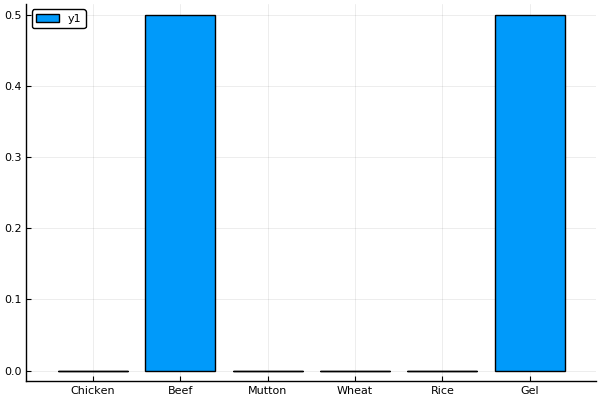

In [13]:
using StatsPlots
pyplot()
bar(optimal_mix[!,:ingredient], optimal_mix[!,:mix])

It's probably not reasonable that half of the food is just filler! Now let's suppose that Whiskas has a rule that only 30% of the contents can be gel. Modify the model and get the new optimal mix. How does it compare to the original solution?

In [14]:
function find_optimal_mix2(data, min_requirements, max_requirements)
    n = nrow(data)
    
    m = Model(with_optimizer(Gurobi.Optimizer,TimeLimit=60))
    
    @variable(m, x[1:n] >= 0)
    
    @objective(m, Min, sum(data[i, :cost] * x[i] for i = 1:n))
    
    for r in nutrients
         @constraint(m, min_requirements[r] <= sum(data[i, r] * x[i] for i = 1:n) <= max_requirements[r])
    end
    
    @constraint(m, x[data[!,:ingredient] .== "Gel"] .<= 0.3)

    @constraint(m, sum(x) == 1)
    
    optimize!(m)
    
    return(JuMP.value.(x))
    

end

mix2 = find_optimal_mix2(data, min_requirements, max_requirements)

optimal_mix2 = DataFrame(ingredient=data[!,:ingredient], mix=mix2)



Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 6 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e-01, 2e+01]
  Objective range  [1e-02, 1e-01]
  Bounds range     [4e-01, 8e+00]
  RHS range        [3e-01, 1e+00]
Presolve removed 1 rows and 4 columns
Presolve time: 0.00s
Presolved: 5 rows, 6 columns, 25 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e-02   2.450000e+00   0.000000e+00      0s
       5    5.8345794e-02   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.00 seconds
Optimal objective  5.834579439e-02


,ingredient,mix
,String,Float64
1,Chicken,0.0
2,Beef,0.131776
3,Mutton,0.385047
4,Wheat,0.0
5,Rice,0.183178
6,Gel,0.3


In [15]:
cost_data2 = join(data, optimal_mix2; on=:ingredient)
sum(cost_data2[!,:cost].*cost_data2[!,:mix])

0.05834579439252337

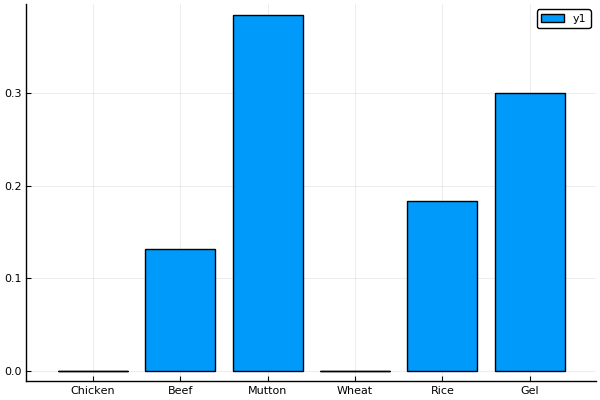

In [16]:
bar(optimal_mix2[!,:ingredient], optimal_mix2[!,:mix])